<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/Codes/Copy_of_01_diffusion_model_training_checkpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EUROSAT Diffusion

### Envrionment Set Up

In [2]:
!pip install -U diffusers[training] #in case collab resets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from huggingface_hub import notebook_login

notebook_login()

!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Loading the Dataset

In [3]:
# REMOVE any old copy
!rm -rf /content/EuroSAT

# COPY cleanly
!cp -r /content/drive/MyDrive/data/eurosat-dataset/6/EuroSAT /content/


In [4]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/content/EuroSAT",
)

print(dataset)


Resolving data files:   0%|          | 0/27000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


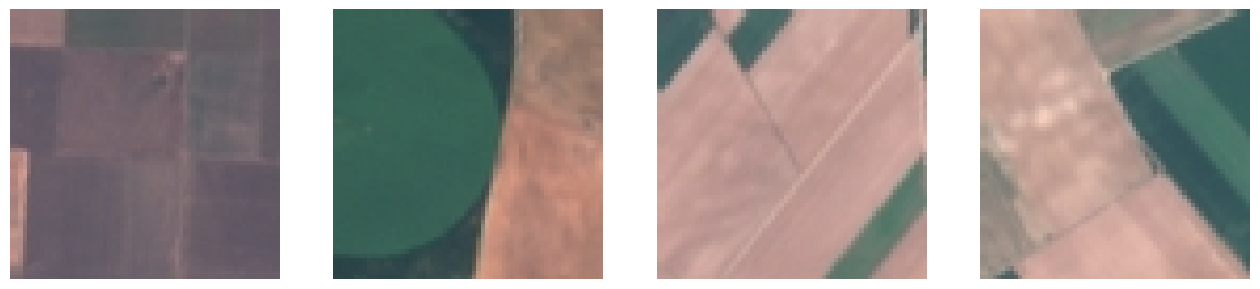

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):  # Access images from the train set
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

### Preprocessing for Diffusion

In [6]:
from torchvision import transforms

preprocess_diffusion = transforms.Compose([
    #transforms.Resize((256, 256)), #model input unet
    #transforms.CenterCrop(256),
    transforms.ToTensor(), #pytorch tensor for training
    transforms.Normalize([0.5], [0.5]) #normalization
])

def transform(examples):
    images = [preprocess_diffusion(image.convert("RGB")) for image in examples["image"]]
    labels = examples["label"]  # <- Keep the labels
    return {"images": images, "label": labels}
# Apply the batch transform to your dataset
dataset.set_transform(transform)

In [7]:
print(dataset["train"][0])

{'images': tensor([[[ 0.1686,  0.1686,  0.1608,  ..., -0.2000, -0.1843, -0.1922],
         [ 0.1686,  0.1686,  0.1608,  ..., -0.2000, -0.1843, -0.1922],
         [ 0.1216,  0.1137,  0.1451,  ..., -0.2000, -0.2000, -0.1922],
         ...,
         [ 0.1294,  0.1059,  0.0745,  ..., -0.1922, -0.2157, -0.2078],
         [ 0.0353,  0.0353, -0.0039,  ..., -0.1765, -0.1765, -0.1608],
         [-0.0275, -0.0431, -0.0588,  ..., -0.1686, -0.1686, -0.1608]],

        [[-0.0510, -0.0510, -0.0667,  ..., -0.2941, -0.2784, -0.2863],
         [-0.0510, -0.0510, -0.0667,  ..., -0.2941, -0.2784, -0.2863],
         [-0.0824, -0.0902, -0.0824,  ..., -0.2784, -0.2941, -0.2863],
         ...,
         [-0.0902, -0.0824, -0.0824,  ..., -0.2706, -0.2941, -0.2863],
         [-0.1373, -0.1216, -0.1373,  ..., -0.2627, -0.2706, -0.2549],
         [-0.1765, -0.1686, -0.1922,  ..., -0.2549, -0.2627, -0.2549]],

        [[-0.0588, -0.0588, -0.0510,  ..., -0.2157, -0.2000, -0.2078],
         [-0.0588, -0.0588, -0.051

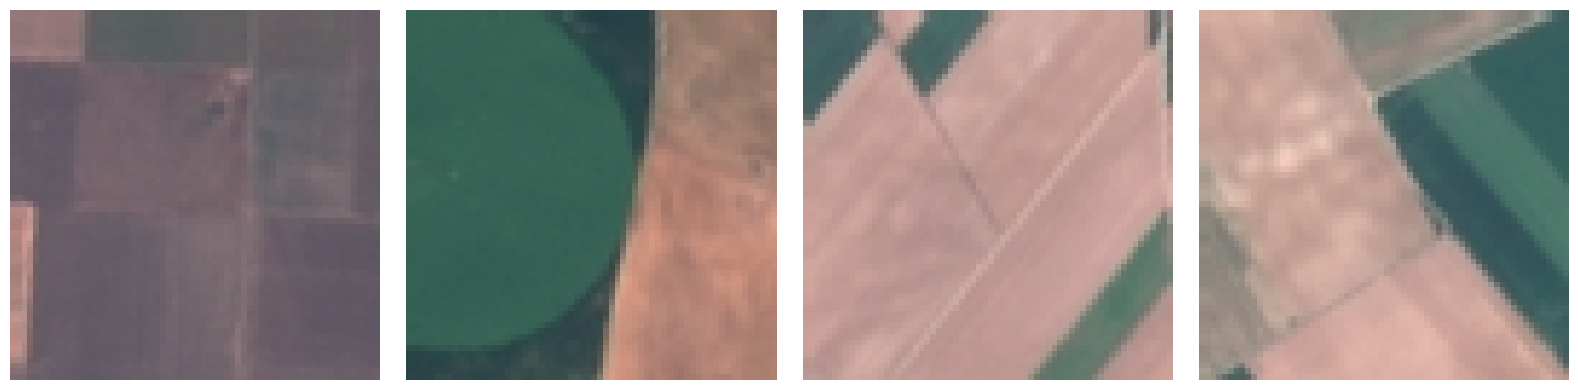

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Load the first 4 samples (batch) from the dataset
batch = dataset["train"][:4]

for i, image in enumerate(batch["images"]):
    # Reverse normalization for display: [-1, 1] → [0, 1]
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    image = (image * 0.5) + 0.5 #reverse normalization

    axs[i].imshow(image)
    axs[i].set_axis_off()

fig.tight_layout()
plt.show()

## Configuration and Dataloader

In [48]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 256
    eval_batch_size = 256  # 48 ~ 10g ram
    num_epochs = 10 #feel free to change, since we will always continue the already improved loss with loading the checkpoints. running this code again only improves the model
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 50
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-eurosat-conditional'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [49]:
import torch

#train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"],
    batch_size=config.train_batch_size,   # ⚡ BIG BATCH
    shuffle=True,
    num_workers=12,    # ⚡ MORE WORKERS
    pin_memory=True,  # ⚡ FAST CPU → GPU transfer
)

In [50]:
import time
start = time.time()

for batch in train_dataloader:
    break  # only load one batch

print(f"Time to load 1 batch: {time.time() - start:.2f} seconds")

Time to load 1 batch: 1.05 seconds


In [51]:
import torch.nn as nn

#num_classes = 10

In [52]:
from diffusers import UNet2DModel
#from diffusers import UNet2DConditionModel


model = UNet2DModel( #CHANGE TO UNet2DModel FOR UNCONDITIONAL
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
    num_class_embeds=10,  # number of classes (e.g., 10 for EuroSAT) COMMENT THIS OUT FOR UNCONDITIONAL
)

In [53]:
#sample_image = dataset["train"][0]["images"].unsqueeze(0)  # ✅ Correct for your dataset
#print("Input shape:", sample_image.shape)  # Should print (1, 3, 128, 128)

#And let's check the output is a tensor of the same exact shape:
#print('Output shape:', model(sample_image, timestep=0).sample.shape)

## Defining the noise scheduler

In [54]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)



In [55]:
print(dataset['train'])  # if you have a 'train' split

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})


## Training

In [56]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)


In [57]:

from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid
#the below was used in the unconditional one but cannot be used for the conditional one because there is no pipeline label argument to provide labels
'''
def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
'''


'\ndef evaluate(config, epoch, pipeline):\n    import torch\n\n    # Sample random class labels\n    class_labels = torch.randint(0, 10, (config.eval_batch_size,), device=pipeline.device)\n\n    # Generate images with class labels\n    images = pipeline(\n        batch_size=config.eval_batch_size,\n        generator=torch.manual_seed(config.seed),\n        class_labels=class_labels,  # 👈 Pass class labels during sampling!\n    ).images\n\n    # Make a grid out of the images\n    image_grid = make_grid(images, rows=4, cols=4)\n\n    # Save the images\n    test_dir = os.path.join(config.output_dir, "samples")\n    os.makedirs(test_dir, exist_ok=True)\n    image_grid.save(f"{test_dir}/{epoch:04d}.png")\n'

new one with checkpoints and mkdir for plot


In [77]:
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

    # Prepare everything (model, optimizer, scheduler, dataloader)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    if accelerator.is_main_process:
        repo_id = None  # important: always define repo_id

        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

    global_step = 0
    epoch_losses = []

    # ======================================================
    # 📦 Try to resume from latest checkpoint if available
    latest_checkpoint = None
    output_dir = Path(config.output_dir)
    checkpoints = sorted(output_dir.glob("checkpoint_epoch_*"), key=lambda p: int(p.name.split("_")[-1]))
    if checkpoints:
        latest_checkpoint = checkpoints[-1]

    if latest_checkpoint:
        print(f"Resuming from checkpoint: {latest_checkpoint}")
        accelerator.load_state(str(latest_checkpoint))
    # ======================================================

    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {config.train_batch_size}")
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # 🔥 Start training loop
    for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            labels = batch['label']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.detach().item()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")

            # ======================
            # 📈 Save loss plot
            if (epoch + 1) % 5 == 0 or epoch == config.num_epochs - 1:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                os.makedirs(os.path.dirname(loss_plot_path), exist_ok=True)  # ✅ Make sure dir exists
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")
            # ======================

            # ======================
            # 🧹 Save full checkpoint (model + optimizer + scheduler)
            if (epoch + 1) % 2 == 0 or epoch == config.num_epochs - 1:
                checkpoint_dir = os.path.join(config.output_dir, f"checkpoint_epoch_{epoch}")
                accelerator.save_state(checkpoint_dir)
                print(f"Checkpoint saved to {checkpoint_dir}")
            # ======================

            # ======================
            # 🖼️ Save generated images
            '''
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)
            # ======================
            '''
            # ======================
            # 💾 Save full model
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Saving model for epoch {epoch}...")
                #pipeline.save_pretrained(config.output_dir)
                accelerator.unwrap_model(model).save_pretrained(config.output_dir)
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                print(f" Model saved successfully!")
            # ======================


## Let's train

In [78]:
from torch.utils.data import DataLoader

# Ensure the "train" split is correctly accessed
train_dataloader = DataLoader(
    dataset["train"],  # Access the 'train' split
    batch_size=config.train_batch_size,  # Set batch size
    shuffle=True
)

print(dataset.keys())  # Check if 'train' exists as a key



dict_keys(['train'])


In [79]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)
#CHANGE THIS WHEN YOU RUN THE CODE: add how many epochs you added since the checkpoints get overwritten

#I have run this code once fully without interrupting the training and the model got safed succesfully:
# yes, 10 epochs
# yes, 10 epochs
# yes, 10 epochs

Launching training on one GPU.
Resuming from checkpoint: ddpm-eurosat-conditional/checkpoint_epoch_9
  Starting training with the following configuration:
   - Number of epochs: 10
   - Batch size: 256
   - Mixed precision: fp16
   - Output directory: ddpm-eurosat-conditional
   - Number of training samples: 27000


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 0 completed. Average loss: 0.0134


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 1 completed. Average loss: 0.0138
Checkpoint saved to ddpm-eurosat-conditional/checkpoint_epoch_1


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 2 completed. Average loss: 0.0134


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 3 completed. Average loss: 0.0135
Checkpoint saved to ddpm-eurosat-conditional/checkpoint_epoch_3


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 4 completed. Average loss: 0.0133
 Loss plot saved to ddpm-eurosat-conditional/loss_plot_epoch_4.png


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 5 completed. Average loss: 0.0141
Checkpoint saved to ddpm-eurosat-conditional/checkpoint_epoch_5


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 6 completed. Average loss: 0.0136


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 7 completed. Average loss: 0.0133
Checkpoint saved to ddpm-eurosat-conditional/checkpoint_epoch_7


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 8 completed. Average loss: 0.0129


  0%|          | 0/106 [00:00<?, ?it/s]


 Epoch 9 completed. Average loss: 0.0131
 Loss plot saved to ddpm-eurosat-conditional/loss_plot_epoch_9.png
Checkpoint saved to ddpm-eurosat-conditional/checkpoint_epoch_9
 Saving model for epoch 9...


optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

Upload 26 LFS files:   0%|          | 0/26 [00:00<?, ?it/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

 Model saved successfully!


## Sample some images

In [80]:
from diffusers import DDPMPipeline

# Rebuild pipeline manually from your UNet + scheduler
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

# Save it cleanly
pipeline.save_pretrained("ddpm-eurosat-conditional")
pipeline = DDPMPipeline.from_pretrained("ddpm-eurosat-conditional")
pipeline = pipeline.to("cuda")


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Class labels for generated images: [3, 9, 8, 0, 3, 7, 2, 6]


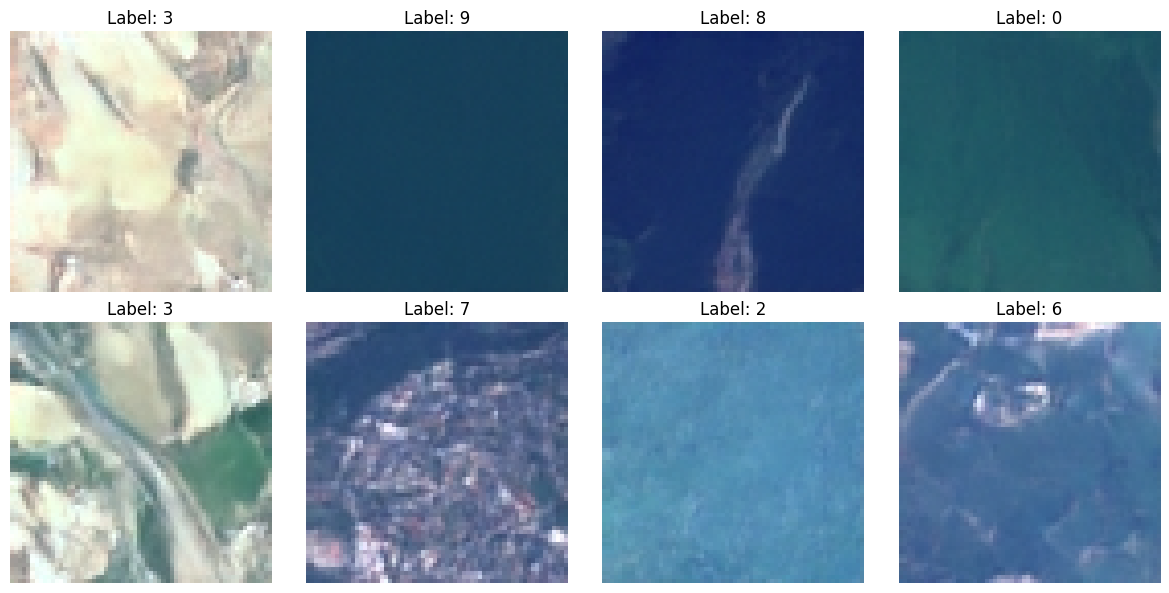

In [81]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Sampling settings
batch_size = 8
image_size = 64  # assuming your images are 64x64
generator = torch.manual_seed(42)  # reproducible random noise

# 2. Prepare random noise
generator = torch.Generator(device="cuda").manual_seed(42)
noise = torch.randn(batch_size, 3, image_size, image_size, device="cuda", generator=generator)

# 3. Prepare timesteps
timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)

# 4. Choose random or specific class labels
# ⚡ Option A: random classes
class_labels = torch.randint(0, 10, (batch_size,), device="cuda")

# ⚡ Option B: generate all images from a specific class (e.g., label 5)
# class_labels = torch.full((batch_size,), 5, device="cuda", dtype=torch.long)

print("Class labels for generated images:", class_labels.tolist())

# 5. Run the sampling
model.eval()
sample = noise
for t in reversed(range(noise_scheduler.config.num_train_timesteps)):
    timesteps.fill_(t)
    with torch.no_grad():
        noise_pred = model(sample, timesteps, class_labels=class_labels).sample
    sample = noise_scheduler.step(noise_pred, t, sample).prev_sample

# 6. Denormalize: [-1, 1] → [0, 1]
sample = (sample / 2 + 0.5).clamp(0, 1)

# 7. Plot the results
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(sample[i].cpu())
    axs[i//4, i%4].imshow(img)
    axs[i//4, i%4].set_title(f"Label: {class_labels[i].item()}")
    axs[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()
